In [1]:
import gzip
import json
import math
import os
import random
import re
from collections import defaultdict
from time import time
from urllib.request import urlopen

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy
import sklearn
import tensorflow as tf
from gem.embedding.gf import GraphFactorization
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from gem.embedding.lle import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne import SDNE
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation import visualize_embedding as viz
from gem.utils import graph_util
from karateclub import DeepWalk
from networkx.algorithms import (bipartite, centrality, clustering, community,
                                 shortest_paths)
from nltk.corpus import stopwords
from numpy import genfromtxt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras

2023-05-13 13:55:03.303752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 13:55:03.483729: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 13:55:06.873781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-13 13:55:06.873937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# Set options to display all columns and rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 10)

# Evaluation

## Top-k metric: MAP@K and MAR@K

+ We can recommend at most k items for each user.

+ Order matters, so it’s better to submit more certain recommendations first, followed by recommendations we are less sure about.
    
+ Precision and Recall at Cutoff k: 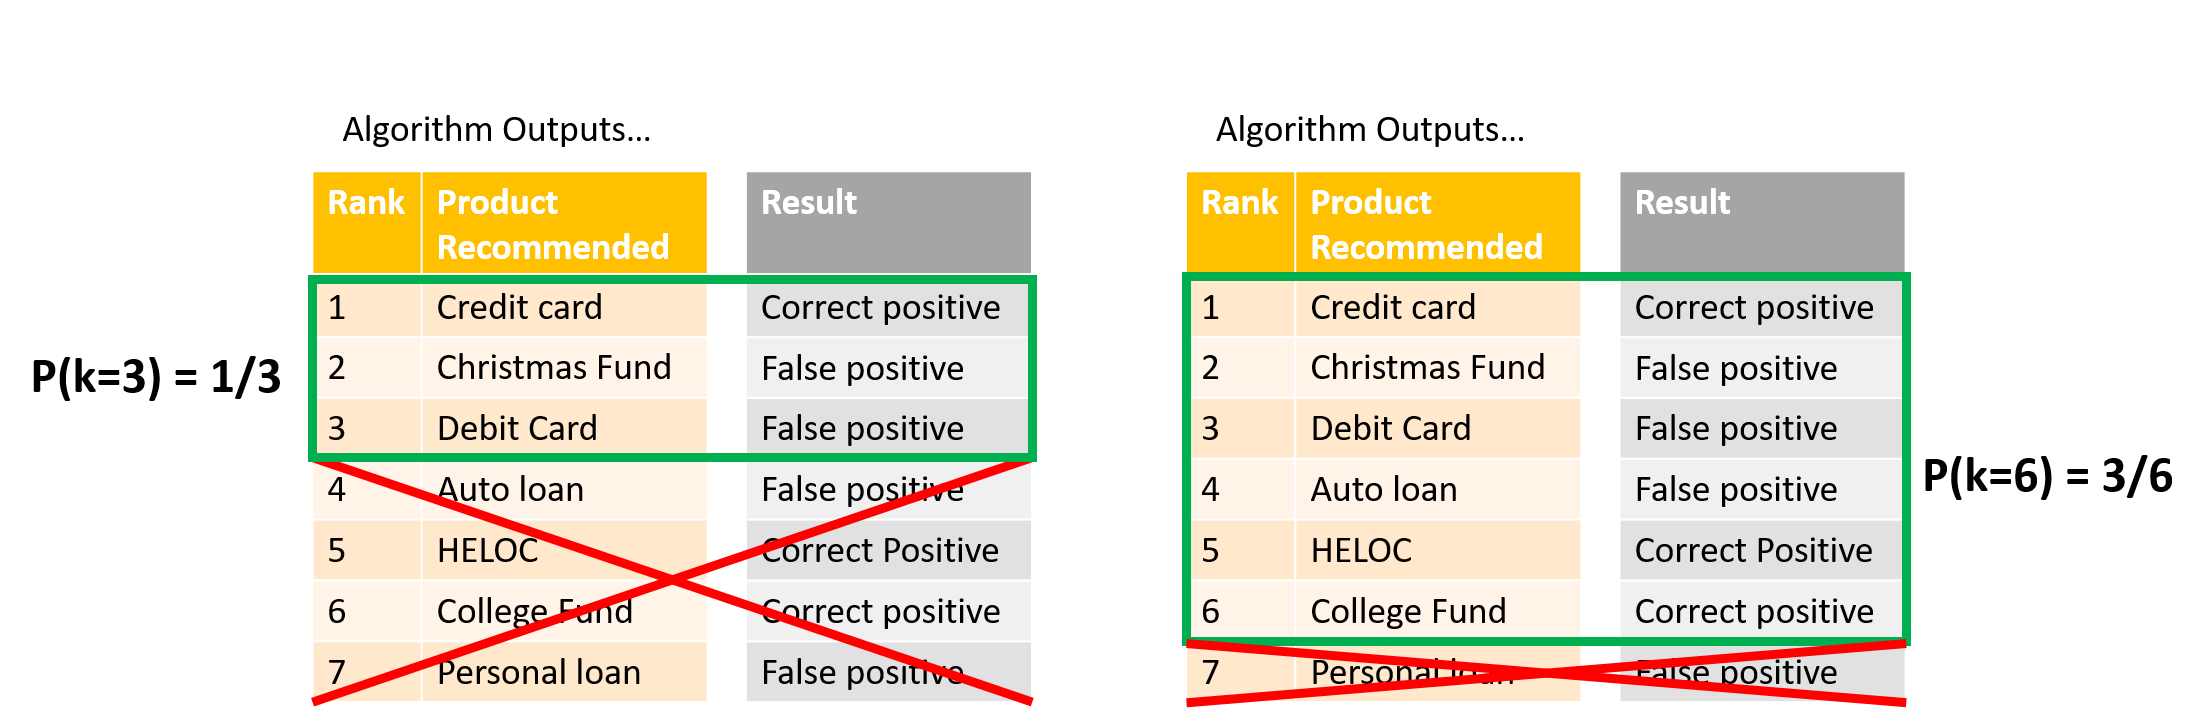. Precision and Recall at cutoff k, P(k) and r(k), are simply the precision and recall calculated by considering only the subset of your recommendations from rank 1 through k.

+ Average Precision: 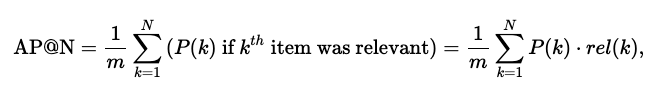. where rel(k) is just an indicator that says whether that kth item was relevant (rel(k)=1) or not (rel(k)=0). 

        E.g: we recommend 1 0 1 0 0 1 0 0 1 1 -->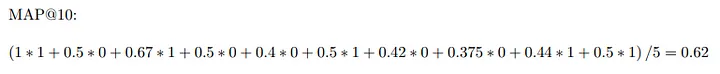

+ The more revelant recommendation and the more precise of the ranking --> the higher AP. E.g: 1 1 1 0 1 1 0 0 0 is higher than 1 0 1 0 0 1 0 0 1 1 

+ MAP computes the mean of the Average Precision (AP) over all the users: 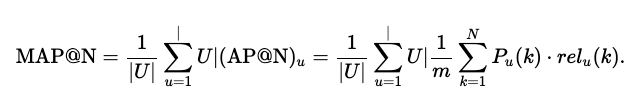


In [3]:
# Function that computes the root mean squared error (or RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
# Function to compute the RMSE score obtained on the testing set by a model
def get_score_model(model, reviewerID, asin, df_test):
    # Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(df_test[reviewerID], X_test[asin])
    # Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    # Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test["overall"])
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [5]:
def average_precision_at_n(recommendations, ground_truth, n):
    """
    Calculate the Average Precision at N (AP@N) metric.
    :param recommendations: List of recommended items.
    :param ground_truth: List of ground truth items.
    :param n: Cutoff value.
    :return: AP@N score.
    """
    recommended_n = recommendations[:n]
    hits = np.isin(recommended_n, ground_truth)

    if np.sum(hits) == 0:
        return 0.0

    precision = np.cumsum(hits) / np.arange(1, n + 1)
    ap_n = np.sum(precision * hits) / np.sum(hits)
    return ap_n


def mean_average_precision_at_n(recommendations_list, ground_truth_list, n):
    """
    Calculate the Mean Average Precision at N (MAP@N) metric.
    :param recommendations_list: List of lists of recommended items.
    :param ground_truth_list: List of lists of ground truth items.
    :param n: Cutoff value.
    :return: MAP@N score.
    """
    num_users = len(recommendations_list)
    ap_list = []

    for i in range(num_users):
        ap_n = average_precision_at_n(
            recommendations_list[i], ground_truth_list[i], n
        )
        ap_list.append(ap_n)
    map_n = np.mean(ap_list)
    return map_n


# Example usage
recommendations_list = [
    [1, 2, 3, 4, 5],
    [2, 4, 2, 8, 10],
]  # List of recommended items for multiple users
ground_truth_list = [
    [3, 4, 5],
    [2, 4, 6],
]  # List of ground truth items for multiple users
n = 5  # Cutoff value

map_at_n = mean_average_precision_at_n(
    recommendations_list, ground_truth_list, n
)
print("MAP@{}:".format(n), map_at_n)

MAP@5: 0.7388888888888888


In [6]:
def get_score(rating_matrix, y_true, ascen=True):
    """rating_matrix is user-item matrix"""
    # Obtain sorted indices for each row
    if ascen == False:
        rating_matrix_argsort = np.argsort(rating_matrix.values, axis=1)[
            :, ::-1
        ]
    else:
        rating_matrix_argsort = np.argsort(rating_matrix.values, axis=1)
    # Create a new DataFrame with sorted indices and columns
    rating_matrix_argsort_df = pd.DataFrame(
        rating_matrix.columns[rating_matrix_argsort], index=rating_matrix.index
    )

    y_pred = rating_matrix_argsort_df.loc[y_true.keys()]
    y_pred = dict(zip(y_pred.index, y_pred.iloc[:, :10].values))

    # Example usage
    recommendations_list = list(
        y_pred.values()
    )  # List of recommended items for multiple users
    ground_truth_list = list(
        y_true.values()
    )  # List of ground truth items for multiple users
    n = 10  # Cutoff value

    map_at_n = mean_average_precision_at_n(
        recommendations_list, ground_truth_list, n
    )
    return map_at_n, y_pred

In [41]:
y_true = df_test.groupby(["reviewerID"])["asin"].unique().to_dict()
y_true

{'A0034986DWR7WEDQN0GV': array(['B00068GEJM', 'B0007RDVD4', 'B000CPAV7A', 'B000E2CVI8',
        'B000GU3EB6', 'B000HBIDO2', 'B000HE6H6K', 'B001GJ3E2K',
        'B001GJ3DZS', 'B001GJ3EJS', 'B001MXTOKQ', 'B0043YIFGU',
        'B004HX1DZM', 'B005Z2K89Q'], dtype=object),
 'A0473259F6GQNBD88IYN': array(['B000AS1XYO', 'B001PWA0IO', 'B00J8DPFKA', 'B00K5LJZZU',
        'B00PKSAWDC', 'B01127IER0'], dtype=object),
 'A04871372ZZ3WUQ2YCCL': array(['B000HBM42Y', 'B014IU2EE2'], dtype=object),
 'A0598317G3T7URZAR3W3': array(['B0024E6UE0'], dtype=object),
 'A0743345UFTOA4V1Z7W': array(['B000BZX28Q', 'B00OA66IGK'], dtype=object),
 'A0790668279F8WD0TYJA': array(['B0000AZ9KS', 'B000VU57YS', 'B01G5EA74I', 'B006RMC8J6'],
       dtype=object),
 'A07936821FOVJO6NP4Q8': array(['B0006H938M', 'B0083W18IU', 'B000BQWHDQ'], dtype=object),
 'A0846724PR6DLXCOTZ18': array(['B010W2K55K', 'B0186P1MUW', 'B01FCZ71MC'], dtype=object),
 'A0955928C2RRWOWZN7UC': array(['B000NIXMV8', 'B000NJ1HIW', 'B00DSD58DA', 'B00FVSQAIM',


In [136]:
y_true_items = (
    df_meta_data_filter.drop_duplicates(["asin"])
    .set_index(["asin"])["also_view"]
    .to_dict()
)

In [142]:
filtered_dict = {
    key: value for key, value in y_true_items.items() if len(value) > 0
}

## Compare Benchmarks

In [ ]:
random_model_performance = get_score(y_pred_random, y_true, ascen=True)
popularity_mode_performance = mean_average_precision_at_n(
    list(y_pred_popularity_rating.values()), list(y_true.values()), n
)
SVD_model_performance = get_score(df_inference_svd.T, y_true)
cb_mode_performance = mean_average_precision_at_n(
    list(y_pred.values()), list(y_true.values()), n
)
cf_model_performance = get_score(df_inference_cf.T, y_true)

In [ ]:
random_model_performance, popularity_mode_performance

In [ ]:
SVD_model_performance, cb_model_performance, cf_model_performance

# Models

## Random

In [124]:
random_model_performances = []
for i in range(10):
    rows = df_test["reviewerID"].nunique()
    cols = df_test["asin"].nunique()

    y_pred_random = pd.DataFrame(
        np.random.rand(rows, cols),
        columns=df_test["asin"].unique(),
        index=df_test["reviewerID"].unique(),
    )

    random_model_performance, y_pred = get_score(
        y_pred_random, y_true, ascen=False
    )
    random_model_performances.append(random_model_performance)

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


KeyboardInterrupt: 

In [125]:
random_model_performances = []
for i in range(10):
    rows = df_test["reviewerID"].nunique()
    cols = df_test["asin"].nunique()

    y_pred_random = pd.DataFrame(
        np.random.rand(rows, cols),
        columns=df_test["asin"].unique(),
        index=df_test["reviewerID"].unique(),
    )

    random_model_performance, y_pred = get_score(
        y_pred_random, y_true, ascen=False
    )
    random_model_performances.append(random_model_performance)

8

In [126]:
np.mean(random_model_performances)

0.0012330950868910538

## Average Rating of All Data

In [ ]:
average = df_train["overall"].mean()

In [ ]:
def train_average_model(reviewerID, asin):
    return 4.06


def average_model_inference(train_average_model, reviewerID, asin):
    # Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(reviewerID, asin)
    # Predict the rating for every user-movie tuple
    y_pred = np.array(
        [
            train_average_model(reviewerID, asin)
            for (reviewerID, asin) in id_pairs
        ]
    )
    return y_pred

In [ ]:
# Function to compute the RMSE score obtained on the testing set by a model
def get_score_model(y_pred, df_test):
    # Extract the actual ratings given by the users in the test data
    y_true = np.array(df_test["overall"])
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [ ]:
y_pred = average_model_inference(
    train_average_model, df_test["reviewerID"], df_test["asin"]
)
y_pred

In [ ]:
get_score_model(y_pred, df_test)

In [ ]:
rows = df_test["reviewerID"].nunique()
cols = df_test["asin"].nunique()
value = average

y_pred_average_model = pd.DataFrame(
    np.full((rows, cols), value),
    columns=df_test["asin"].unique(),
    index=df_test["reviewerID"].unique(),
)

map_at_n = get_score(y_pred_average_model, y_true)
map_at_n

In [ ]:
random: MAP@10 --> 0.001
CB_model: MAP@10 --> 0.00027
average: MAP@10 --> 0.0009
SVD: ---> 0.0002
CF: -- > 0.001
Popularity: MAP@10: 0.021

## Popular Rating

Uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

In [14]:
new_df = df_train.groupby("asin").filter(lambda x: x["overall"].count() >= 50)

In [15]:
ratings_mean_count = pd.DataFrame(new_df.groupby("asin")["overall"].mean())
ratings_mean_count["rating_counts"] = pd.DataFrame(
    new_df.groupby("asin")["overall"].count()
)

In [16]:
ratings_mean_count.head()

,overall,rating_counts
asin,,
B00008RW9U,4.578947,133
B00008RW9V,4.544304,79
B0000AXDFT,4.010101,99
B0000AXNMO,4.700855,117
B0000AXPDU,3.930000,100


In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ratings_mean_count.values)
scaled_data

array([[0.81203008, 0.05200501],
       [0.7965642 , 0.01817043],
       [0.55808081, 0.03070175],
       ...,
       [0.80867347, 0.02130326],
       [0.88454433, 0.00501253],
       [0.83353511, 0.0056391 ]])

In [18]:
ratings_mean_count["final_weight"] = scaled_data.sum(axis=1)

In [19]:
plt.style.use("ggplot")

Text(0.5, 1.0, 'rating distribution')

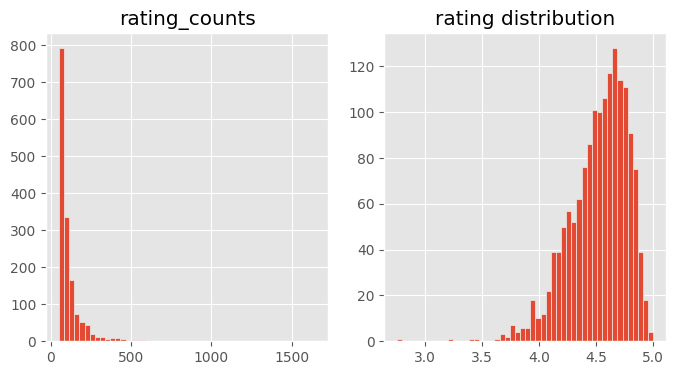

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.rcParams["patch.force_edgecolor"] = True

axes[0].hist(ratings_mean_count["rating_counts"], bins=50)
axes[1].hist(ratings_mean_count["overall"], bins=50)

axes[0].set_title("rating_counts")
axes[1].set_title("rating distribution")

In [21]:
Top10 = (
    ratings_mean_count.sort_values(["final_weight"], ascending=False)
    .head(10)["final_weight"]
    .index.tolist()
)
ratings_mean_count.loc[Top10]

,overall,rating_counts,final_weight
asin,,,
B000CITK8S,4.750570,1315,1.681254
B000W20LKK,4.168894,1646,1.628971
B0015Y5848,4.673709,852,1.356841
B0002UEOLO,4.786174,622,1.262938
B000GL19WG,4.786174,622,1.262938
B000NCOKZQ,4.818336,589,1.256619
B0010E00T6,4.602703,740,1.254966
B001V8U12M,4.801029,583,1.245134
B002OUMVSS,4.646889,691,1.243990


In [22]:
y_pred_popularity_rating = {}
for key in y_true.keys():
    y_pred_popularity_rating[key] = Top10

In [23]:
# Example usage
recommendations_list = list(
    y_pred_popularity_rating.values()
)  # List of recommended items for multiple users
ground_truth_list = list(
    y_true.values()
)  # List of ground truth items for multiple users
n = 10  # Cutoff value

map_at_n = mean_average_precision_at_n(
    recommendations_list, ground_truth_list, n
)
print("MAP@{}:".format(n), map_at_n)

MAP@10: 0.021232986168159038


# Collaborative Filtering Recommender Systems

Use all the users collaborate to generate the rating set.

The goal of a collaborative filtering recommender system is to generate two vectors: 
+ For each user, a 'parameter vector' and bias.
+ For each movie, a feature vector of the same size which embodies some description of the items. 

The dot product of the two vectors plus the bias term should produce an estimate of the rating the user might give to that items.
+ These vectors are simultaneously learned by using the existing user/item ratings as training data.

<div>
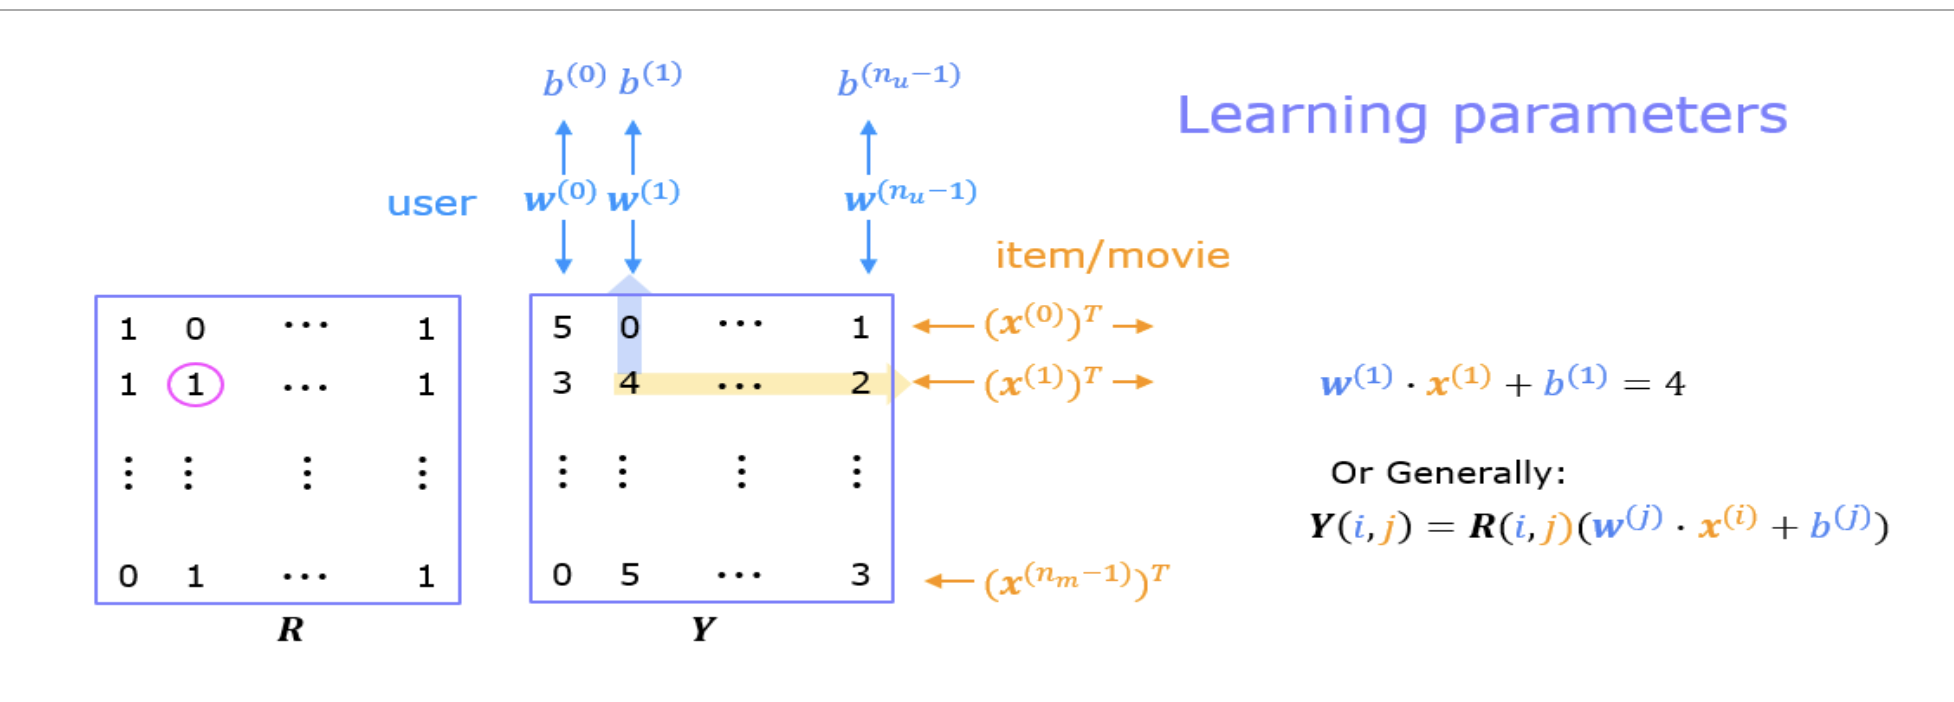
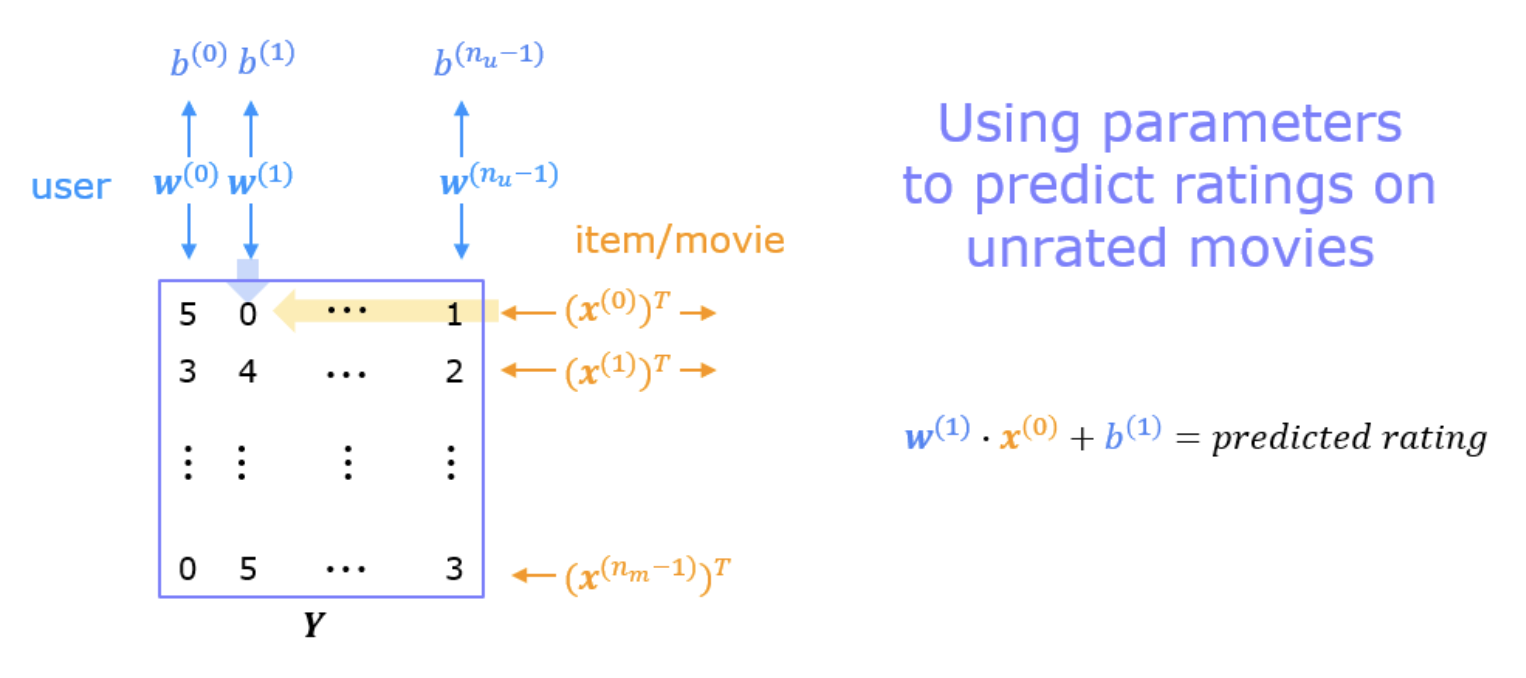
</div>

Below, you will load the movie dataset into the variables  𝑌 and  𝑅

+ The matrix 𝑌 (a 𝑛𝑚×𝑛𝑢 matrix) stores the ratings  𝑦(𝑖,𝑗)
+ The matrix  𝑅 is an binary-valued indicator matrix, where  𝑅(𝑖,𝑗)=1 if user 𝑗 gave a rating to movie  𝑖, and  𝑅(𝑖,𝑗)=0 otherwise.

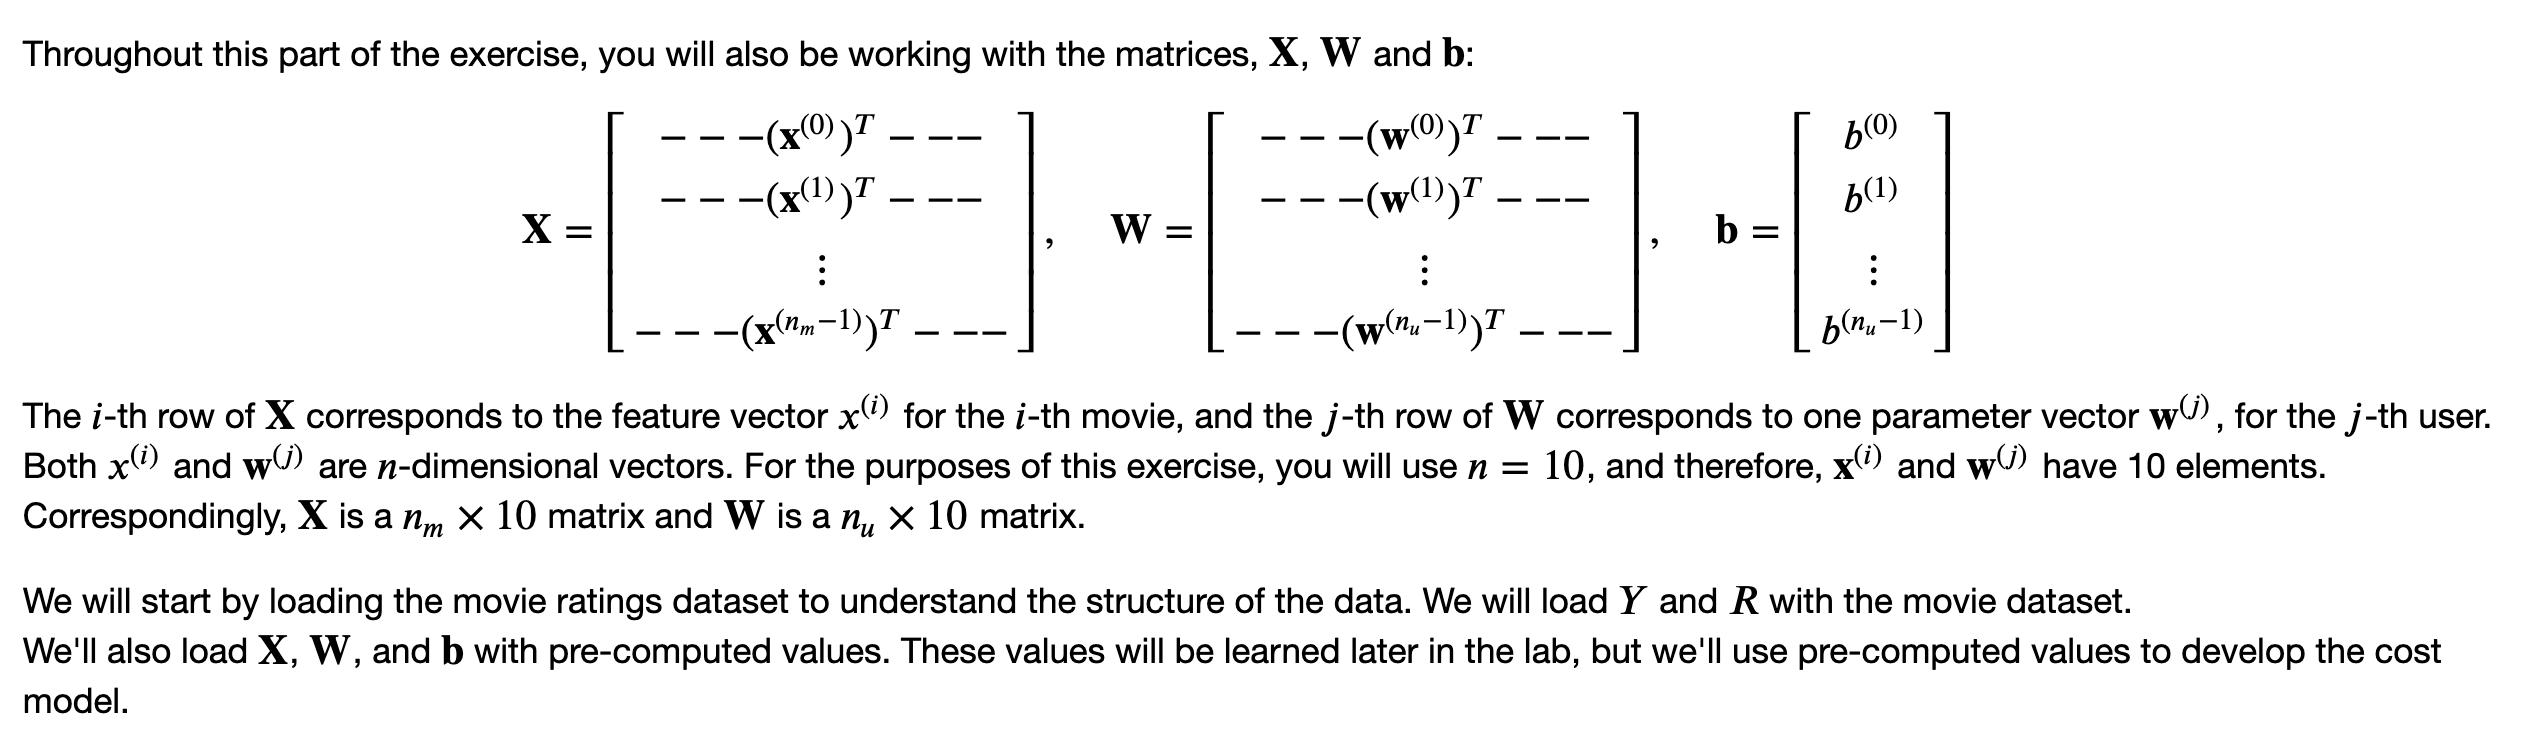

In [24]:
def initialize_param(num_items, num_features, num_users):
    # Set Initial Parameters (W, X), use tf.Variable to track these variables
    tf.random.set_seed(1234)  # for consistent results
    W = tf.Variable(
        tf.random.normal((num_users, num_features), dtype=tf.float64), name="W"
    )
    X = tf.Variable(
        tf.random.normal((num_items, num_features), dtype=tf.float64), name="X"
    )
    b = tf.Variable(
        tf.random.normal((1, num_users), dtype=tf.float64), name="b"
    )
    return X, W, b

In [25]:
df_rating = (
    df_train[["reviewerID", "asin", "overall"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [26]:
rating_matrix = pd.crosstab(
    index=df_rating["asin"],
    columns=df_rating["reviewerID"],
    values=df_rating["overall"],
    aggfunc="max",
)

rating_matrix = rating_matrix.fillna(0)
np.mean(rating_matrix.values), np.max(rating_matrix.values), np.min(
    rating_matrix.values
)

(0.0029924926475109856, 5.0, 0.0)

In [27]:
Y = rating_matrix.values
R = Y.copy()
# Create mask for non-zero values
mask = R != 0
# Replace non-zero values with 1
R[mask] = 1

In [28]:
# Normalize the Dataset
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Only include real ratings R(i,j)=1.
    [Ynorm, Ymean] = normalizeRatings(Y, R) normalized Y so that each movie
    has a rating of 0 on average. Unrated moves then have a mean rating (0)
    Returns the mean rating in Ymean.
    """
    Ymean = (np.sum(Y * R, axis=1) / (np.sum(R, axis=1) + 1e-12)).reshape(
        -1, 1
    )
    Ynorm = Y - np.multiply(Ymean, R)
    return (Ynorm, Ymean)


Ynorm, Ymean = normalizeRatings(Y, R)

In [29]:
np.mean(Ymean), np.max(Ymean), np.min(Ymean)

(4.4453152516065835, 4.999999999999906, 0.9999999999989999)

In [ ]:
np.mean(Ynorm), np.max(Ynorm), np.min(Ynorm)

## Deep Neural Network

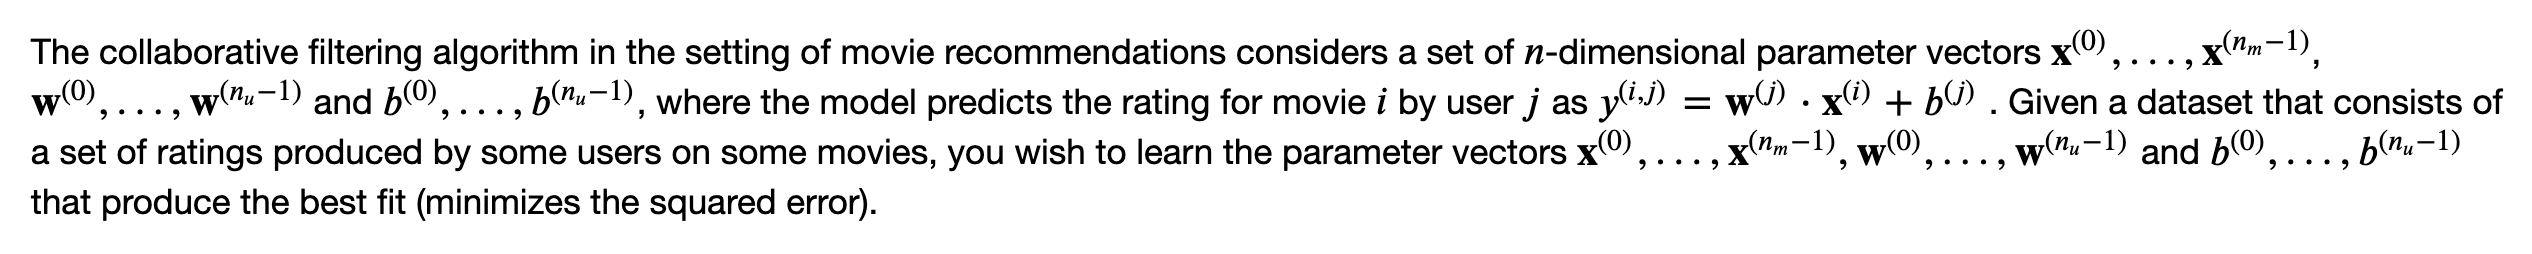

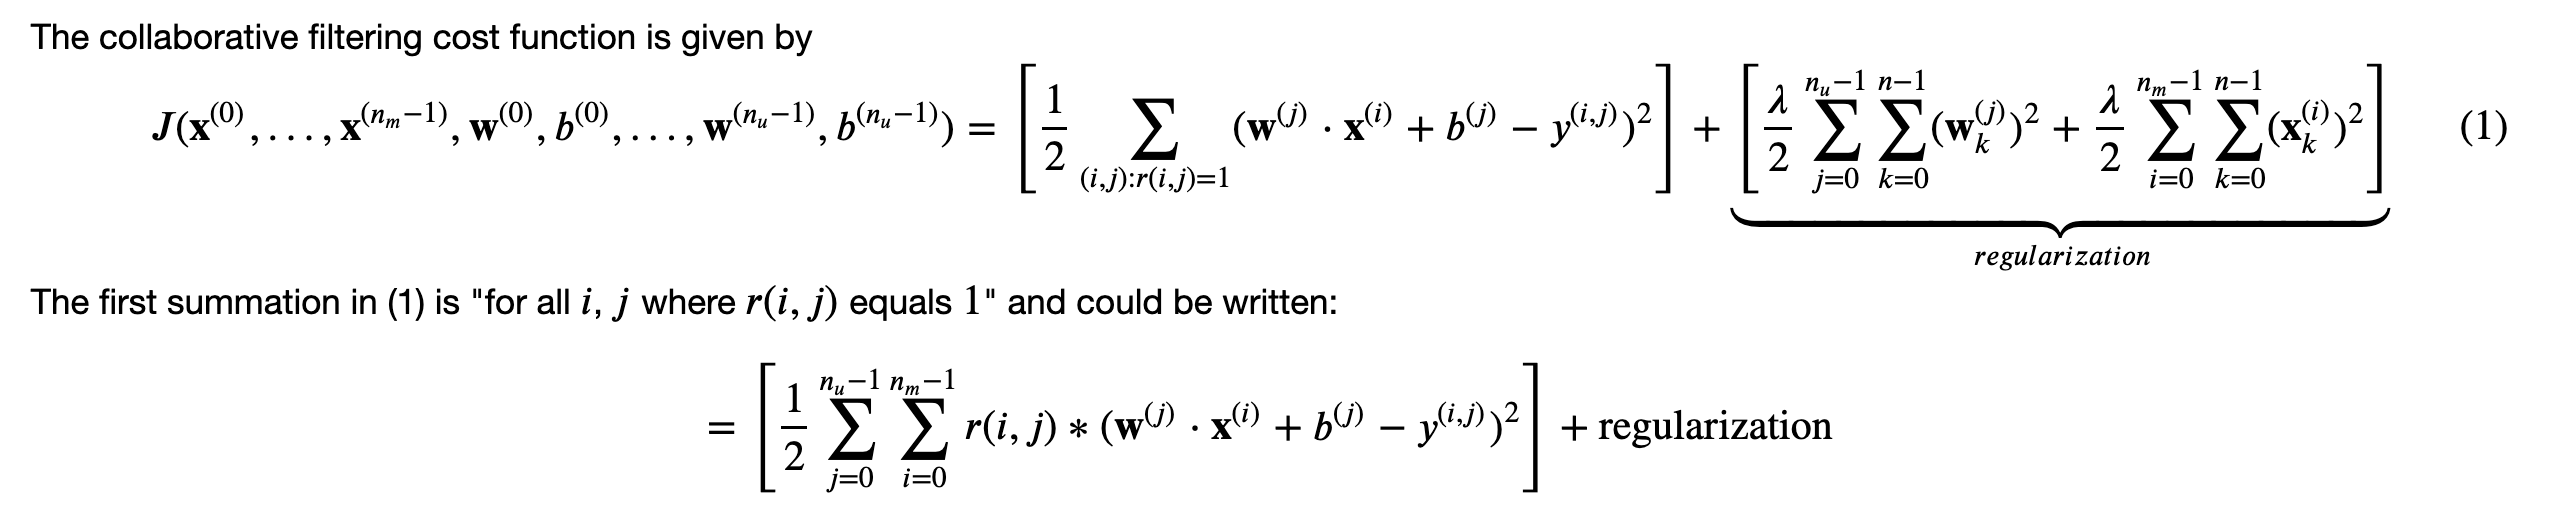

In [30]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_ / 2) * (
        tf.reduce_sum(X**2) + tf.reduce_sum(W**2)
    )
    return J

In [31]:
Y.shape

(9766, 45375)

In [32]:
#  Useful Values
num_items, num_users = Y.shape
num_features = 100
X, W, b = initialize_param(num_items, num_features, num_users)
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

2023-05-13 13:59:37.532510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-13 13:59:37.532567: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [33]:
print("Y", Y.shape, "R", R.shape)
print("X", X.shape)
print("W", W.shape)
print("b", b.shape)

print("num_features", num_features)
print("num_movies", num_items)
print("num_users", num_users)

Y (9766, 45375) R (9766, 45375)
X (9766, 100)
W (45375, 100)
b (1, 45375)
num_features 100
num_movies 9766
num_users 45375


In [34]:
iterations = 50
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost
    with tf.GradientTape() as tape:
        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(cost_value, [X, W, b])

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, [X, W, b]))

    # Log periodically.
    if iter % 10 == 0:
        print(f"Training loss at iteration {iter}: {cost_value:0.1f}")

Training loss at iteration 0: 17729039.4
Training loss at iteration 10: 2759273.6
Training loss at iteration 20: 1538162.8
Training loss at iteration 30: 934266.4
Training loss at iteration 40: 601451.5


In [35]:
# Make a prediction using trained weights and biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
# restore the mean
pm = p + Ymean

In [ ]:
df_inference_cf = pd.DataFrame(
    pm, columns=rating_matrix.columns, index=rating_matrix.index
)

In [54]:
df_inference_cf.to_parquet("df_inference_svd.parquet")

In [42]:
cf_model_performance, y_pred = get_score(
    df_inference_cf.T, y_true, ascen=False
)
cf_model_performance

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0008448890418048188

## Matrix factorization version

In [43]:
from scipy.sparse.linalg import svds

n_factors = 100
U, sigma, Vt = svds(Ynorm, n_factors)

In [ ]:
print(U.shape, Vt.shape)

(9766, 100) (100, 45375)


In [ ]:
sigma = np.diag(sigma)
print(sigma)

recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + Ymean

[[14.79877212  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         14.84299455  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         14.88237006 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 30.38910941  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         35.12773669
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  46.48496371]]


In [ ]:
recalculated_ratings.shape

(9766, 45375)

In [ ]:
df_inference_svd = pd.DataFrame(
    recalculated_ratings,
    columns=rating_matrix.columns,
    index=rating_matrix.index,
)

In [53]:
df_inference_svd.to_parquet("df_inference_svd.parquet")

In [ ]:
matrix_factorization_performance, y_pred = get_score(
    df_inference_svd.T, y_true, ascen=False
)
matrix_factorization_performance

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0009583207092103889

# Content Based Method

Generated two vectors
<div>
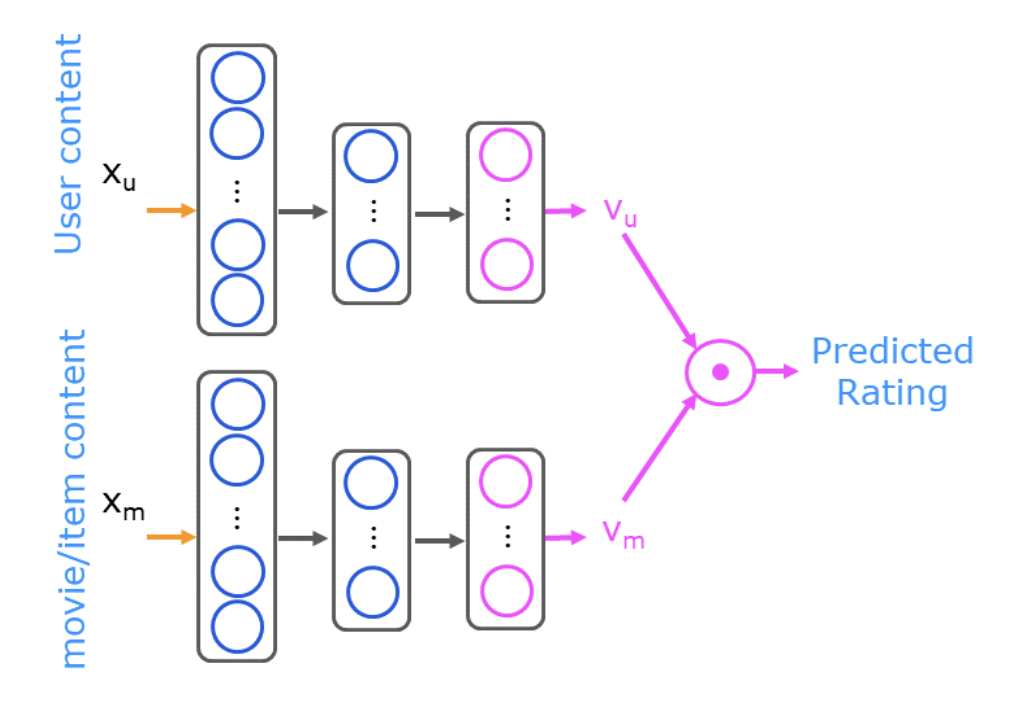
</div>

 + a user vector 
 + an item/movie vector whose dot product would predict a rating. 
 
The vectors can be derived solely from:
 + the ratings: aggregate rating such as: mean, max of each cate
 + other information available about the user and/or movie that may improve the prediction. 

## Derive Item vectors

In [ ]:
def create_mark_col(df_meta_data_filter, cols):
    for col in cols:
        df_meta_data_filter["Is_" + col] = 1
        df_meta_data_filter.loc[
            df_meta_data_filter[col] == "", "Is_" + col
        ] = 0
    return df_meta_data_filter


df_meta_data_filter = create_mark_col(
    df_meta_data_filter, ["description", "price", "feature", "rank"]
)
df_meta_data_filter.columns

In [ ]:
top10_cates = [
    "Automotive",
    "Tools & Home Improvement",
    "Sports & Outdoors",
    "Amazon Home",
    "Car Electronics",
    "Cell Phones & Accessories",
    "Industrial & Scientific",
    "Tools &amp; Home Improvement",
    "Baby",
    "Health & Personal Care",
]

In [ ]:
def rank_to_number(text_row):
    text_row = str(text_row)
    if text_row == "":
        return -1
    number = re.findall(r"\d+", text_row)[0]
    return int(number)


def rank_to_text(text_row):
    try:
        text_row = str(text_row)
        if text_row == "":
            return "Unknown"
        text_row = text_row.partition("in")[2].strip()
        return text_row[: text_row.index("(")]
    except:
        return text_row[: text_row.index("&")]

In [ ]:
def encode(df):
    df["categories"] = df["main_cat"]
    df.loc[df["main_cat"].isin(top10_cates) == False, "categories"] = "Others"
    encoded_df = pd.get_dummies(df, columns=["categories"])
    return encoded_df

In [ ]:
df_meta_data_filter = encode(df_meta_data_filter)
df_meta_data_filter.columns

In [ ]:
items_cols = [
    "asin",
    "Is_description",
    "Is_price",
    "Is_feature",
    "Is_rank",
    "categories_Amazon Home",
    "categories_Automotive",
    "categories_Baby",
    "categories_Car Electronics",
    "categories_Cell Phones & Accessories",
    "categories_Health & Personal Care",
    "categories_Industrial & Scientific",
    "categories_Others",
    "categories_Sports & Outdoors",
    "categories_Tools & Home Improvement",
    "categories_Tools &amp; Home Improvement",
]

df_item_features = (
    df_meta_data_filter[items_cols].drop_duplicates().set_index(["asin"])
)

In [ ]:
df_item_features.to_parquet(
    "/home/longnt70/libs/graph/amazon-dataset/df_item_features.parquet"
)

## Derive User vectors

In [56]:
df_item_features = pd.read_parquet(
    "/home/longnt70/R&D/graph/amazon-dataset/df_item_features.parquet"
)

In [57]:
df_good_review = df_train[df_train["overall"] >= 4][
    ["reviewerID", "asin", "overall"]
].copy()
df_good_review.head(2)

,reviewerID,asin,overall
0,AM54IIJJVLW0C,B00000IWHE,5.0
2,AHV9Z1EDYO5WK,B00000IWHE,4.0


Create vector user from vector items

In [58]:
user_item = df_good_review.groupby(["reviewerID"])["asin"].unique()


def generate_user_vector(list_of_items):
    return df_item_features.loc[list_of_items].mean().values


dict_vector_user = user_item.map(generate_user_vector).to_dict()
mean_vector = (pd.DataFrame(dict_vector_user).T).mean().values

NameError: name 'vector_user' is not defined

In [83]:
set_fill_users = set(df_train["reviewerID"]).difference(
    set(df_good_review["reviewerID"])
)
for user in set_fill_users:
    dict_vector_user[user] = mean_vector

In [84]:
len(dict_vector_user), len(set(df_train["reviewerID"]))

(45375, 45375)

In [85]:
df_vector_user = pd.DataFrame(dict_vector_user).T
df_vector_user.columns = df_item_features.columns

In [86]:
df_vector_user.shape, df_item_features.shape

((45375, 15), (9766, 15))

## Traditional CB

In [87]:
# Calculate the Euclidean distance matrix
distance_matrix = cdist(
    df_vector_user.values, df_item_features.values, metric="cosine"
)

# Print the distance matrix
df_distance = pd.DataFrame(
    distance_matrix, index=df_vector_user.index, columns=df_item_features.index
)

In [88]:
df_distance.to_parquet("df_distance_cb.parquet")

the lower cosine distance --> more similar

In [89]:
map_at_n, y_pred = get_score(df_distance, y_true, ascen=True)
map_at_n

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0014580077450777331

## Neural Network for Content Based

In [90]:
def load_data(df_vector_user, df_item_features, df_train, df_test):
    user_train = df_vector_user.loc[df_train["reviewerID"].values].values
    item_train = df_item_features.loc[df_train["asin"].values].values
    y_train = df_train["overall"].values

    user_test = df_vector_user.loc[df_test["reviewerID"].values].values
    item_test = df_item_features.loc[df_test["asin"].values].values
    y_test = df_test["overall"].values

    item_features = df_item_features.columns.tolist()
    user_features = df_vector_user.columns.tolist()

    return (
        user_train,
        item_train,
        y_train,
        user_test,
        item_test,
        y_test,
        item_features,
        user_features,
    )


(
    user_train,
    item_train,
    y_train,
    user_test,
    item_test,
    y_test,
    item_features,
    user_features,
) = load_data(df_vector_user, df_item_features, df_train, df_test)

In [91]:
num_user_features = len(user_features)
num_item_features = len(item_features)
num_user_features, num_item_features

(15, 15)

In [92]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(
    np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train))
)
print(
    np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train))
)

# Trainsform for test
item_test = scalerItem.transform(item_test)
user_test = scalerUser.transform(user_test)
y_test = scalerTarget.transform(y_test.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

# GRADED_CELL
# UNQ_C1

num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

item_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = keras.Model([input_user, input_item], output)

model.summary()

tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss=cost_fn)

model.fit([user_train, item_train], y_train, epochs=30)

model.evaluate([user_train, item_train], y_train), model.evaluate(
    [user_test, item_test], y_test
)

True
True


In [ ]:
y_pred = model.predict([user_test, item_test])
y_pred_orig = scalerTarget.inverse_transform(y_pred.reshape(-1, 1))

3061/3061 [==============================] - 4s 1ms/step


## Inference

In [ ]:
item_vecs = df_item_features.values
user_vecs = df_vector_user.values

Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [ ]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))  # input layer
vm_m = item_NN(input_item_m)  # use the trained item_NN
vm_m = tf.linalg.l2_normalize(
    vm_m, axis=1
)  # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()

scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs)
print(f"size of all predicted movie feature vectors: {vms.shape}")

items_to_vec = pd.DataFrame(vms, index=df_item_features.index)

input_user = tf.keras.layers.Input(shape=(num_user_features))  # input layer
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)
model_u = tf.keras.Model(input_user, vu)
model_u.summary()

scaled_user_vecs = scalerUser.transform(user_vecs)
vus = model_u.predict(scaled_user_vecs)
print(f"size of all predicted movie feature vectors: {vus.shape}")
users_to_vec = pd.DataFrame(vus, index=df_vector_user.index)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15)]              0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                41120     
                                                                 
 tf.math.l2_normalize_2 (TFO  (None, 32)               0         
 pLambda)                                                        
                                                                 
Total params: 41,120
Trainable params: 41,120
Non-trainable params: 0
_________________________________________________________________
306/306 [==============================] - 0s 1ms/step
size of all predicted movie feature vectors: (9766, 32)


In [ ]:
similar_df = pd.DataFrame(
    np.dot(users_to_vec.values, items_to_vec.values.T),
    index=users_to_vec.index,
    columns=items_to_vec.index,
)

In [ ]:
map_at_n, y_pred = get_score(similar_df, y_true, ascen=False)
map_at_n

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0011903192804734914

In [ ]:
similar_df.to_parquet("df_similar_neuralnet_cb.parquet")

# Graph embedding + Content Based

In [ ]:
os.environ["https_proxy"] = "http://proxy.hcm.fpt.vn:80/"
os.environ["http_proxy"] = "http://proxy.hcm.fpt.vn:80/"

In [ ]:
df_train.head(2)

In [ ]:
df_sample = df_train[["reviewerID", "asin", "overall"]]
df_sample

In [ ]:
# Add nodes and edges to the bipartite graph
G = nx.Graph()
for _, row in df_sample.iterrows():
    G.add_edge(row["reviewerID"], row["asin"], overall=row["overall"])

# Assign the 'bipartite' attribute to nodes
reviewers = set(df_sample["reviewerID"])
items = set(df_sample["asin"])

G.add_nodes_from(reviewers, bipartite=0)
G.add_nodes_from(items, bipartite=1)

In [ ]:
reviewers = set(df_sample["reviewerID"])
items = set(df_sample["asin"])

len(reviewers), len(items)

## Traditional Graph Features

In [ ]:
# Node degree
degrees = G.degree()
# Filter the degrees based on node types
user_degrees = {
    node: degree for node, degree in degrees if G.nodes[node]["bipartite"] == 0
}
item_degrees = {
    node: degree for node, degree in degrees if G.nodes[node]["bipartite"] == 1
}

# Node centrality measures
degree_centrality = centrality.degree_centrality(G)
closeness_centrality = centrality.closeness_centrality(G)
betweenness_centrality = centrality.betweenness_centrality(G)

# Calculate local clustering coefficient for all nodes
clustering_coefficients = nx.clustering(G)

# Run PageRank algorithm
pagerank_scores = nx.pagerank(G)

In [ ]:
degrees = G.degree()

In [ ]:
degree_centrality = centrality.degree_centrality(G)

In [ ]:
closeness_centrality = centrality.closeness_centrality(G)

In [ ]:
betweenness_centrality = centrality.betweenness_centrality(G)

In [ ]:
clustering_coefficients = nx.clustering(G)

In [ ]:
pagerank_scores = nx.pagerank(G)

In [ ]:
user_degree_centrality = {
    key: value for key, value in degree_centrality.items() if key in reviewers
}
item_degree_centrality = {
    key: value for key, value in degree_centrality.items() if key in items
}

user_closeness_centrality = {
    key: value
    for key, value in closeness_centrality.items()
    if key in reviewers
}
item_closeness_centrality = {
    key: value for key, value in closeness_centrality.items() if key in items
}

user_betweenness_centrality = {
    key: value
    for key, value in betweenness_centrality.items()
    if key in reviewers
}
item_betweenness_centrality = {
    key: value for key, value in betweenness_centrality.items() if key in items
}

user_clustering_coefficients = {
    key: value
    for key, value in clustering_coefficients.items()
    if key in reviewers
}
item_clustering_coefficients = {
    key: value
    for key, value in clustering_coefficients.items()
    if key in items
}

user_page_rank = {
    key: value for key, value in pagerank_scores.items() if key in reviewers
}
item_page_rank = {
    key: value for key, value in pagerank_scores.items() if key in items
}

In [ ]:
user_embedding = []
for data_dict in [
    user_degree_centrality,
    user_closeness_centrality,
    user_betweenness_centrality,
    user_clustering_coefficients,
    user_page_rank,
]:
    user_embedding.append(pd.Series(data_dict))

df_user_embedding = pd.concat(user_embedding, axis=1)
df_user_embedding.columns = [
    "user_degree_centrality",
    "user_closeness_centrality",
    "user_betweenness_centrality",
    "user_clustering_coefficients",
    "user_page_rank",
]
df_user_embedding.to_parquet("df_user_embedding.parquet")

In [ ]:
item_embedding = []
for data_dict in [
    item_degree_centrality,
    item_closeness_centrality,
    item_betweenness_centrality,
    item_clustering_coefficients,
    item_page_rank,
]:
    item_embedding.append(pd.Series(data_dict))

df_item_embedding = pd.concat(item_embedding, axis=1)
df_item_embedding.columns = [
    "item_degree_centrality",
    "item_closeness_centrality",
    "item_betweenness_centrality",
    "item_clustering_coefficients",
    "item_page_rank",
]
df_item_embedding.to_parquet("df_item_embedding.parquet")

In [ ]:
df_user_embedding = pd.read_parquet("df_user_embedding.parquet")
df_item_embedding = pd.read_parquet("df_item_embedding.parquet")

In [107]:
# Calculate the Euclidean distance matrix
distance_matrix_graph = cdist(
    df_user_embedding.values, df_item_embedding.values, metric="cosine"
)
# Print the distance matrix
df_distance_graph = pd.DataFrame(
    distance_matrix,
    index=df_user_embedding.index,
    columns=df_item_embedding.index,
)
map_at_n, y_pred = get_score(df_distance_graph, y_true, ascen=True)
map_at_n

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0005136662906532419

In [108]:
df_distance_graph.to_parquet("df_distance_graph.parquet")

## Graph Embeddings

### Node2vec

In [ ]:
from node2vec import Node2Vec

In [ ]:
# Create an instance of Node2Vec with default parameters
node2vec = Node2Vec(
    G,
    dimensions=128,
    walk_length=80,
    num_walks=10,
    p=1,
    q=1,
    weight_key="weight",
    workers=8,
    seed=1,
)

# Learn the node embeddings with Node2Vec
model = node2vec.fit()

# Get the embeddings for all nodes in the graph
embeddings = {node: model.wv[node] for node in G.nodes()}

In [ ]:
df_node2vec = pd.DataFrame.from_dict(embeddings, orient="index")
df_node2vec.columns = ["dim_" + str(x) for x in df_node2vec.columns]
df_user_node2vec = df_node2vec.loc[reviewers]
df_item_node2vec = df_node2vec.loc[items]

In [ ]:
df_user_node2vec.to_parquet("df_user_node2vec.parquet")
df_item_node2vec.to_parquet("df_item_node2vec.parquet")

In [109]:
df_user_node2vec = pd.read_parquet("df_user_node2vec.parquet")
df_item_node2vec = pd.read_parquet("df_item_node2vec.parquet")

In [110]:
# Calculate the Euclidean distance matrix
distance_node2vec = cdist(
    df_user_node2vec.values, df_item_node2vec.values, metric="cosine"
)
# Print the distance matrix
df_distance_node2vec = pd.DataFrame(
    distance_node2vec,
    index=df_user_node2vec.index,
    columns=df_item_node2vec.index,
)
map_at_n, y_pred = get_score(df_distance_node2vec, y_true, ascen=True)
map_at_n

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.006342273779996199

In [111]:
df_distance_node2vec.to_parquet("df_distance_node2vec.parquet")

### Node2vec + Neural Network Content Based

In [112]:
def load_data(df_vector_user, df_item_features, df_train, df_test):
    user_train = df_vector_user.loc[df_train["reviewerID"].values].values
    item_train = df_item_features.loc[df_train["asin"].values].values
    y_train = df_train["overall"].values

    user_test = df_vector_user.loc[df_test["reviewerID"].values].values
    item_test = df_item_features.loc[df_test["asin"].values].values
    y_test = df_test["overall"].values

    item_features = df_item_features.columns.tolist()
    user_features = df_vector_user.columns.tolist()

    return (
        user_train,
        item_train,
        y_train,
        user_test,
        item_test,
        y_test,
        item_features,
        user_features,
    )


(
    user_train,
    item_train,
    y_train,
    user_test,
    item_test,
    y_test,
    item_features,
    user_features,
) = load_data(df_user_node2vec, df_item_node2vec, df_train, df_test)

In [116]:
num_user_features = len(user_features)
num_item_features = len(item_features)

In [117]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(
    np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train))
)
print(
    np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train))
)

# Trainsform for test
item_test = scalerItem.transform(item_test)
user_test = scalerUser.transform(user_test)
y_test = scalerTarget.transform(y_test.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

# GRADED_CELL
# UNQ_C1

num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

item_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = keras.Model([input_user, input_item], output)

model.summary()

tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss=cost_fn)

model.fit([user_train, item_train], y_train, epochs=30)

model.evaluate([user_train, item_train], y_train), model.evaluate(
    [user_test, item_test], y_test
)

True
True
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 32)           70048       ['input_7[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 32)           70048       ['input_8[0][0]']                
                                                                                  

(0.13595619797706604, 0.2972414195537567)

In [118]:
item_vecs = df_item_node2vec.values
user_vecs = df_user_node2vec.values

In [119]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))  # input layer
vm_m = item_NN(input_item_m)  # use the trained item_NN
vm_m = tf.linalg.l2_normalize(
    vm_m, axis=1
)  # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()

scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs)
print(f"size of all predicted movie feature vectors: {vms.shape}")

items_to_vec = pd.DataFrame(vms, index=df_item_node2vec.index)

input_user = tf.keras.layers.Input(shape=(num_user_features))  # input layer
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)
model_u = tf.keras.Model(input_user, vu)
model_u.summary()

scaled_user_vecs = scalerUser.transform(user_vecs)
vus = model_u.predict(scaled_user_vecs)
print(f"size of all predicted movie feature vectors: {vus.shape}")
users_to_vec = pd.DataFrame(vus, index=df_user_node2vec.index)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential_5 (Sequential)   (None, 32)                70048     
                                                                 
 tf.math.l2_normalize_8 (TFO  (None, 32)               0         
 pLambda)                                                        
                                                                 
Total params: 70,048
Trainable params: 70,048
Non-trainable params: 0
_________________________________________________________________
306/306 [==============================] - 0s 965us/step
size of all predicted movie feature vectors: (9766, 32)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

In [120]:
similar_df_hybrid = pd.DataFrame(
    np.dot(users_to_vec.values, items_to_vec.values.T),
    index=users_to_vec.index,
    columns=items_to_vec.index,
)

In [121]:
map_at_n, y_pred = get_score(similar_df_hybrid, y_true, ascen=False)
map_at_n

/tmp/ipykernel_9277/3029331003.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rating_matrix.columns[rating_matrix_argsort],


0.0009002426113932639

In [122]:
similar_df_hybrid.to_parquet("similar_df_hybrid.parquet")

## Projection

In [ ]:
# Create the projection onto the 'items' nodes
items_projection = nx.bipartite.projected_graph(G, items)

# Create the projection onto the 'reviewers' nodes
reviewers_projection = nx.bipartite.projected_graph(G, reviewers)

In [ ]:
len(items_projection.nodes()), len(reviewers_projection.nodes())

In [ ]:
for index, graph in enumerate([items_projection, reviewers_projection]):
    # Create an instance of Node2Vec with default parameters
    node2vec_projection = Node2Vec(
        graph,
        dimensions=128,
        walk_length=80,
        num_walks=10,
        p=1,
        q=1,
        weight_key="weight",
        workers=8,
        seed=1,
    )

    # Learn the node embeddings with Node2Vec
    model = node2vec.fit()

    # Get the embeddings for all nodes in the graph
    embeddings = {node: model.wv[node] for node in G.nodes()}

    df_node2vec = pd.DataFrame.from_dict(embeddings, orient="index")
    df_node2vec.columns = ["dim_" + str(x) for x in df_node2vec.columns]

    if index == 0:
        df_node2vec.to_parquet("item_projection_embedding.parquet")
    else:
        df_node2vec.to_parquet("user_projection_embedding.parquet")

## nxt-gem

In [ ]:
gf = GraphFactorization(
    d=2, data_set=None, max_iter=10000, eta=1 * 10**-4, regu=1.0
)

gf.learn_embedding(G)
embeddings = gf.get_embedding()

In [ ]:
models = list()
# Load the models you want to run
models.append(
    GraphFactorization(
        d=2, max_iter=50000, eta=1 * 10**-4, regu=1.0, data_set=None
    )
)
models.append(HOPE(d=4, beta=0.01))
models.append(LaplacianEigenmaps(d=2))
models.append(LocallyLinearEmbedding(d=2))
print(
    "Num nodes: %d, num edges: %d" % (G.number_of_nodes(), G.number_of_edges())
)

for embedding in models:
    try:
        t1 = time()
        # Learn embedding - accepts a networkx graph or file with edge list
        Y = embedding.learn_embedding(
            graph=G, is_weighted=True, no_python=True
        )
        print(
            embedding.get_method_name()
            + ":\n\tTraining time: %f" % (time() - t1)
        )
        # Evaluate on graph reconstruction
        (
            MAP,
            prec_curv,
            err,
            err_baseline,
        ) = gr.evaluateStaticGraphReconstruction(G, embedding, Y, None)
        # ---------------------------------------------------------------------------------
        # ---------------------------------------------------------------------------------
        print(
            ("\tMAP: {} \t preccision curve: {}\n\n\n\n" + "-" * 100).format(
                MAP, prec_curv[:5]
            )
        )
    except:
        print("error", embedding.get_method_name())

In [ ]:
gf = GraphFactorization(
    d=2, data_set=None, max_iter=10000, eta=1 * 10**-4, regu=1.0
)

gf.learn_embedding(G)
embeddings = gf.get_embedding()

In [ ]:
T = nx.barbell_graph(m1=10, m2=4)

## deep walk

In [ ]:
# Perform DeepWalk on the bipartite graph
dw = DeepWalk(walk_number=10, walk_length=80, workers=16, dimensions=64)

# Generate random walks
dw.fit(G)

# Get the embeddings for all nodes
deep_walk_embeddings = dw.get_embeddings()